In [4]:
import sys
sys.path.append('..')

In [5]:
# ckpt = '2501/COSEM_jrc-hela-UnetClassifier-l2/3/'
ckpt = '2501/COSEM_jrc-hela-UnetClassifier-l2/6'
evaluate_test_data = True

training_rootdir = '/group/jug/ashesh/training/diffsplit/'

In [6]:
import yaml
import os
import glob
import torch

def model_checkpoint_fpath(ckpt, fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(ckpt, fname=None):
    fpath = model_checkpoint_fpath(ckpt, fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train"]
    return {k: opt[k]['value'] for k in keys}

In [7]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os

classifier_ckpt = os.path.join(training_rootdir, ckpt)

opt = load_config(classifier_ckpt)
model_opt = opt['model']
model = TimePredictor(
    in_channel=model_opt['unet']['in_channel'],
    out_channel=model_opt['unet']['out_channel'],
    norm_groups=model_opt['unet']['norm_groups'],
    inner_channel=model_opt['unet']['inner_channel'],
    channel_mults=model_opt['unet']['channel_multiplier'],
    attn_res=model_opt['unet']['attn_res'],
    res_blocks=model_opt['unet']['res_blocks'],
    dropout=model_opt['unet']['dropout'],
    image_size=opt['datasets']['patch_size'],
    )
model = model.cuda()
model.load_state_dict(torch.load(os.path.join(classifier_ckpt,'best_time_predictor.pth')), strict=True)


# loading dataset.
if evaluate_test_data:
    if opt['datasets']['train']['name'] == 'Hagen':
        opt['datasets']['val']['datapath'] = {
        'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
        'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
        }
    elif opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
        opt['datasets']['val']['datapath'] = "/group/jug/ashesh/bleedthroughsimulation/jrc_hela-3/train-val-test-split/test_jrc_hela-3_bleedthrough_EGFP_Venus_R3.0_S4_D1_Ex100.0ms.tif"
    else:
        raise NotImplementedError(f'{opt["datasets"]["train"]["name"]} not implemented')

if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False



# data
train_set, val_set = get_datasets(opt, tiled_pred=False)


INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.2 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


TimePredictor
Read from /group/jug/ashesh/bleedthroughsimulation/jrc_hela-3/train-val-test-split/train_jrc_hela-3_bleedthrough_EGFP_Venus_R3.0_S4_D1_Ex100.0ms.tif (96, 700, 1400, 3)
Computing mean and std for normalization
[TimePredictorDataset] Data: 96x3x(700, 1400) Patch:256 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False ChW:[1.0, 1.0]
Adding Gaussian noise with std factor:  0.05
Read from /group/jug/ashesh/bleedthroughsimulation/jrc_hela-3/train-val-test-split/test_jrc_hela-3_bleedthrough_EGFP_Venus_R3.0_S4_D1_Ex100.0ms.tif (96, 700, 700, 3)
Computing mean and std for normalization
[TimePredictorDataset] Data: 96x3x(700, 700) Patch:256 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False ChW:[1.0, 1.0]


In [5]:
from model.normalizer import NormalizerXT
from tqdm import tqdm 
data_mean_arr = []
data_std_arr = []
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)
xt_normalizer = NormalizerXT()
normalizer_count = 20
for _ in tqdm(range(normalizer_count)):
    bar = enumerate(train_loader)
    for i, (x, t_float) in bar:
        x = x.cuda()
        t_float = t_float.cuda()
        x = xt_normalizer.normalize(x,t_float, update=True)
        data_mean_arr.append(xt_normalizer.data_mean.cpu().numpy())
        data_std_arr.append(xt_normalizer.data_std.cpu().numpy())
# num_timesteps = 100
# input_normalization_dict = compute_input_normalization_dict(val_set._data_dict, num_timesteps, val_set._mean_target, val_set._std_target)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:55<00:00,  2.76s/it]


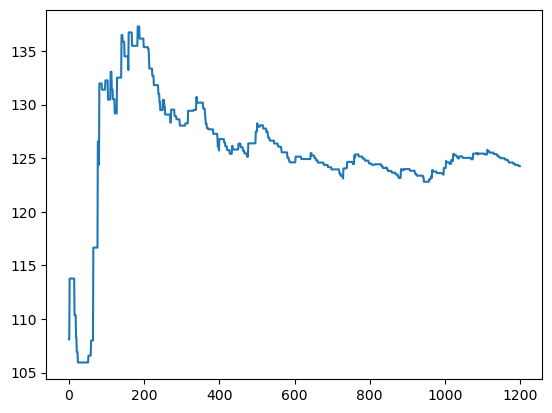

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.stack(data_mean_arr)[:,50])

In [7]:
from tqdm import tqdm
import numpy as np

num_timesteps = 80
gt = np.arange(0,1.0,1/num_timesteps)
pred_arr = []
inp_arr = []
# mean_inp = -0.7193205 
# std_inp = 0.18258347
# def normalize(inp):
#     return 2*(inp - inp_min)/(inp_max-inp_min) - 1
# def min_max_normalize(img, t_int):
#     t_min, t_max = input_normalization_dict[t_int]
#     return 2*(img - t_min)/(t_max - t_min) -1
for mixing_t in tqdm(gt):
    val_set.set_fixed_t(mixing_t)
    dloader = torch.utils.data.DataLoader(
                val_set,
                batch_size=16,
                shuffle=False,
                num_workers=2,
                pin_memory=True)
    for data in dloader:
        inp, t_float = data
        assert torch.std(t_float) < 1e-6, f'{t_float}'
        assert t_float[0] == mixing_t, f'{t_float} != {mixing_t}'
        inp = inp.cuda()
        t_float = t_float.cuda()
        inp = xt_normalizer.normalize(inp, t_float)
        inp_arr.append(inp.cpu().numpy())
        with torch.no_grad():
            pred = model(inp.cuda())
            pred_arr.append(pred.cpu().numpy())
all_pred = np.concatenate(pred_arr).reshape(len(gt),-1)
inp_arr = np.concatenate(inp_arr,axis=0)


  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [02:00<00:00,  1.50s/it]


In [8]:
all_pred = np.concatenate(pred_arr).reshape(len(gt),-1)
inp_arr = np.concatenate(inp_arr,axis=0)


/tmp/ipykernel_43156/2798052624.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(gt,gt, 'k--', color='black')


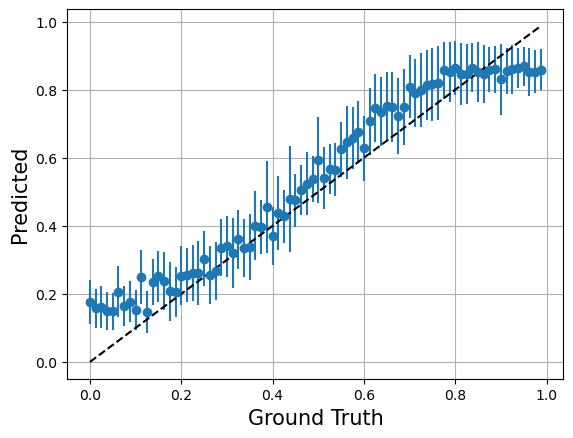

In [9]:
import matplotlib.pyplot as plt

err = all_pred.std(axis=1)
avg_pred = all_pred.mean(axis=1)
_,ax  = plt.subplots()
# plot with error bars
ax.errorbar(gt, avg_pred, yerr=err, fmt='o')
ax.plot(gt,gt, 'k--', color='black')
ax.set_xlabel('Ground Truth', fontsize=15)
ax.set_ylabel('Predicted', fontsize=15)
ax.grid()

In [10]:
mse = ((all_pred - gt.reshape(-1,1))**2).mean(axis=1)
dataset_str = opt['datasets']['train']['name']
dataset_str += ' Test' if evaluate_test_data else ' Val'
print(f'{dataset_str} NormCount:{normalizer_count} RMSE: {np.sqrt(mse.mean())}')

COSEM_jrc-hela Test NormCount:20 RMSE: 0.11399008802822845


In [11]:
mse_mean = ((np.mean(all_pred, axis=1) - gt)**2).mean()
mse_median = ((np.median(all_pred, axis=1) - gt)**2).mean()
print(f'{dataset_str} NormCount:{normalizer_count} RMSE wrt Aggregated (mean) prediction: {np.sqrt(mse_mean)}')
print(f'{dataset_str} NormCount:{normalizer_count} RMSE wrt Aggregated (median) prediction: {np.sqrt(mse_median)}')

COSEM_jrc-hela Test NormCount:20 RMSE wrt Aggregated (mean) prediction: 0.07338385015379031
COSEM_jrc-hela Test NormCount:20 RMSE wrt Aggregated (median) prediction: 0.08459480328758699


In [12]:
len(train_set._data_dict[0])

96

In [13]:
# Test dataset

# 1 RMSE: 0.18584609868369045
# 10 COSEM_jrc-hela Test NormCount:10 RMSE: 0.11467985740375906
# 20 COSEM_jrc-hela Test NormCount:20 RMSE: 0.10733180019946625
# COSEM_jrc-hela Test NormCount:50 RMSE: 0.10229460707714132


In [14]:
# COSEM_jrc-hela Test NormCount:50 RMSE: 0.10632874237278825
# COSEM_jrc-hela Test NormCount:20 RMSE: 0.11445337831205459
# COSEM_jrc-hela Test NormCount:10 RMSE: 0.11869922239826158
# COSEM_jrc-hela Test NormCount:1 RMSE: 0.18200486158911253



In [15]:
# RMSE
# RMSE 0.12 (15 times training dataloader was used to generate the patch statistics)
# RMSE 0.164 (1 times training dataloader was used to generate the patch statistics)